# Read Me

- 이 프로젝트는 Kaggle의 폐 사진 데이터셋으로, 정상 폐와 그렇지 않은 폐를 분류하는 CNN 예측 모델을 만든 미니 프로젝트이다.

- 각 레이블 별 이미지의 수
  - COVID(코로나 확진자의 폐 모습)  =>  3616
  - Normal(정상 폐 모습)  =>  10192
  - Viral Pneumonia(바이러스성 폐렴의 폐 모습)  =>  1345
  - Lung_Opacity(폐음영이 있는 폐 모습)  =>  6012

- 위 이미지를 8:2의 비율로 Train / Test 데이터 셋으로 분리

- 이미지의 수가 적기 때문에 TransferLearning을 진행하였음


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime

import tensorflow.keras.utils as utils

import cv2
import zipfile
import shutil
import os
import glob
import random

# 1. 데이터 준비

- https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
- 다운 받은 데이터셋에는 masks폴더에 Semantic Segmentation을 위한 자료가 섞여있음.
- 분류를 위한 학습을 위해 masks폴더는 삭제하고 COVID-19_Radiography.zip으로 압축하여 구글 드라이브에 업로드

## 1-1. 데이터의 경로 설정해주기

In [2]:
#구글 드라이브와 코랩 연결
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
data_path = "/content/gdrive/MyDrive"  # 복사해올 경로

ROOT_DIR = "/content"

shutil.copy(os.path.join(data_path, "COVID-19_Radiography.zip"), ROOT_DIR) # shutil.copy(복사해올 경로, 붙여넣을 경로)

'/content/COVID-19_Radiography.zip'

In [4]:
with zipfile.ZipFile(os.path.join(ROOT_DIR, "COVID-19_Radiography.zip")) as target_file:
  target_file.extractall(ROOT_DIR)
  print("success!")

success!


## 1-2. 데이터 셋 레이블 파악

- COVID             : Covid 확진
---
- Lung_Opacity      : 폐음영(폐 사진에 하얀 부분이 많음 -> 공기가 희박한 것)
---
- Normal: 정상 폐   
---
- Viral Pneumonia : 바이러스성 폐렴의 폐



In [5]:
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "COVID-19_Radiography_Dataset")

file_name_list = glob.glob(os.path.join(DATA_ROOT_DIR, "*"))
file_name_list

['/content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx',
 '/content/COVID-19_Radiography_Dataset/README.md.txt',
 '/content/COVID-19_Radiography_Dataset/Lung_Opacity',
 '/content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx',
 '/content/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx',
 '/content/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx',
 '/content/COVID-19_Radiography_Dataset/Viral Pneumonia',
 '/content/COVID-19_Radiography_Dataset/COVID',
 '/content/COVID-19_Radiography_Dataset/Normal']

## 1-3. 필요한 데이터만 가져오기

- 우리는 폴더들만 가져오면 되기 때문에 os.path.isdir()함수를 사용한다
- os.path.isdir() -> 폴더인지 아닌지 구분해주는 함수(단, 풀 경로가 필요)


In [6]:
label_name_list = []

for filename in file_name_list:
  if os.path.isdir(filename) == True:
    label_name_list.append(filename.split("/")[-1].strip())

In [7]:
label_name_list

['Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Normal']

## 1-4. 학습을 위해 폴더 구조를 Train/Test로 변경

- Train 폴더에 모두 복사한 후, 각 레이블 별로 일부의 사진을 Test 폴더에 이동

[변경 전]
- Covid-19_Radiography
  - COVID
  - Lung_opacity
  - Normal
  - Viral Pneumonia

----
[변경 후]
- Covid-19_Radiography
  - Train
    - COVID
    - Lung-Opacity
    - Normal
    - Viral Pneumonia
  - Test
    - COVID
    - .
    - .
    - Viral Pneumonia

### 1-4-1. Train 디렉토리 만들기

In [8]:
# DATA_ROOT_DIR = "/content/COVID-19_Radiography_Dataset"

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Train")

In [9]:
# label_name_list = ['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID']
for label_name in label_name_list:
  src_dir_path = os.path.join(DATA_ROOT_DIR, label_name)           # 복사해올 경로

  dst_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)     # 붙여넣을 경로

  try:
    shutil.copytree(src_dir_path, dst_dir_path)                    # copytree: 원본 폴더의 내용과 구조를 그대로 유지하면서 새로운 대상 폴더에 복사
    print('copytree of ' + label_name + ' is done!')

  except Exception as err:
    print(str(err))

copytree of Lung_Opacity is done!
copytree of Viral Pneumonia is done!
copytree of COVID is done!
copytree of Normal is done!


In [10]:
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)   # /content/COVID-19_Radiography_Dataset/Train
print(train_label_name_list)

print("================================================")
print("< 각 폴더별 이미지의 갯수 >")
for label in train_label_name_list:
  print(label, " => " , len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label))))

['Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Normal']
< 각 폴더별 이미지의 갯수 >
Lung_Opacity  =>  6012
Viral Pneumonia  =>  1345
COVID  =>  3616
Normal  =>  10192


### 1-4-2. Test 디렉토리 만들기

- Train 디렉토리에서 레이블 별로 일부의 사진을 이동시킨다.

In [11]:
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Test")

if not os.path.exists(TEST_DATA_ROOT_DIR):
  os.mkdir(TEST_DATA_ROOT_DIR)
  print(TEST_DATA_ROOT_DIR, "is created")

for label_name in label_name_list:
  if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))
    print(label_name, "directory is created:")

/content/COVID-19_Radiography_Dataset/Test is created
Lung_Opacity directory is created:
Viral Pneumonia directory is created:
COVID directory is created:
Normal directory is created:


In [12]:
move_ratio = 0.2                                           # 이동시킬 비율 : 20%

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
  src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)      # ex) Train/COVID , Train/Normal
  dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

  train_image_file_list = os.listdir(src)                  # ex) Train/COVID/*.png 모든 이미지 파일

  print("===============================================")

  print("total image nums of {} folder => {}".format(label_name, len(train_image_file_list)))

  np.random.shuffle(train_image_file_list)                  # 이동 전에 이미지 파일들을 한번 랜덤으로 섞어주기

  split_num = int(move_ratio * len(train_image_file_list))  # split_num -> 이동시킬 이미지 파일의 수

  print("Train/{} folder에 있는 이미지 파일 {}개를 Test/{} folder로 이동".format(label_name, split_num, label_name))

  test_image_file_list = train_image_file_list[0:split_num]

  move_num = 0
  for test_image_file in test_image_file_list:
    shutil.move(os.path.join(src, test_image_file), os.path.join(dst, test_image_file))  # shutil.move(출발지, 도착지)

    move_num += 1

  print("Total {} file is moved into Test/{} folder".format(move_num, label_name))
  print("================================================")


total image nums of Lung_Opacity folder => 6012
Train/Lung_Opacity folder에 있는 이미지 파일 1202개를 Test/Lung_Opacity folder로 이동
Total 1202 file is moved into Test/Lung_Opacity folder
total image nums of Viral Pneumonia folder => 1345
Train/Viral Pneumonia folder에 있는 이미지 파일 269개를 Test/Viral Pneumonia folder로 이동
Total 269 file is moved into Test/Viral Pneumonia folder
total image nums of COVID folder => 3616
Train/COVID folder에 있는 이미지 파일 723개를 Test/COVID folder로 이동
Total 723 file is moved into Test/COVID folder
total image nums of Normal folder => 10192
Train/Normal folder에 있는 이미지 파일 2038개를 Test/Normal folder로 이동
Total 2038 file is moved into Test/Normal folder


## 1-5. Train/Test 폴더 별 각 데이터의 수 확인

In [13]:
### 훈련 데이터 갯수
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
  total_file = len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name)))
  print("Train/{}  => {}".format(label_name, total_file))

print("==========================================================")

### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
  total_file = len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name)))
  print("Test/{} => {}".format(label_name, total_file))

['Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Normal']
Train/Lung_Opacity  => 4810
Train/Viral Pneumonia  => 1076
Train/COVID  => 2893
Train/Normal  => 8154
['Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Normal']
Test/Lung_Opacity => 1202
Test/Viral Pneumonia => 269
Test/COVID => 723
Test/Normal => 2038


- CNN 모델을 사용하려면 최소 1만장 정도의 사진이 필요함
- 현재 데이터 셋의 이미지 수가 확연히 부족하기 때문에 ImageDataGenerator를 이용한 전이학습 진행

# 전이학습 진행

## 2-1. ImageDataGenerator 이용

- ImageDataGenerator 사용
- validation_split 사용

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# 폐 사진의 특징을 고려했을 때, 이미지를 회전 시켜서는 안 됨. 따라서 rotation_range는 사용X
# width_shift_range 와 height_shift_range만 사용

train_data = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1, validation_split = 0.2) # train 데이터 셋에서
valid_data = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1,validation_split = 0.2) # validation 데이터 사용
test_data  = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1)

In [ ]:
train_generator = train_data.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse", subset="training")

valid_generator = valid_data.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse", subset="validation")

test_generator = test_data.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse")

Found 13548 images belonging to 4 classes.
Found 3385 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)
print(train_generator.class_mode)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
4
sparse


## 2-2. 모델 학습 이전, ImageDataGenerator를 통해 생성된 임의의 사진 16개 정도 확인

In [ ]:
# next() 메서드는 알아서 다음에 출력해야 할 요소를 반환해줌.

data, label = train_generator.next()          # generator.next()는 opencv의 BGR2RGB 과정들을 모두 생략할 수 있어 편리

np.random.seed(1)                             # 랜덤으로 셔플 하지만 seed를 이용하여 data와 label의 대응관계가 무너지지 않도록.
np.random.shuffle(np.array(data))
np.random.seed(1)
np.random.shuffle(np.array(label))

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

(16, 224, 224, 3) (16,)
[1. 2. 0. 1. 1. 0. 1. 2. 2. 0. 2. 1. 1. 2. 1. 0.]


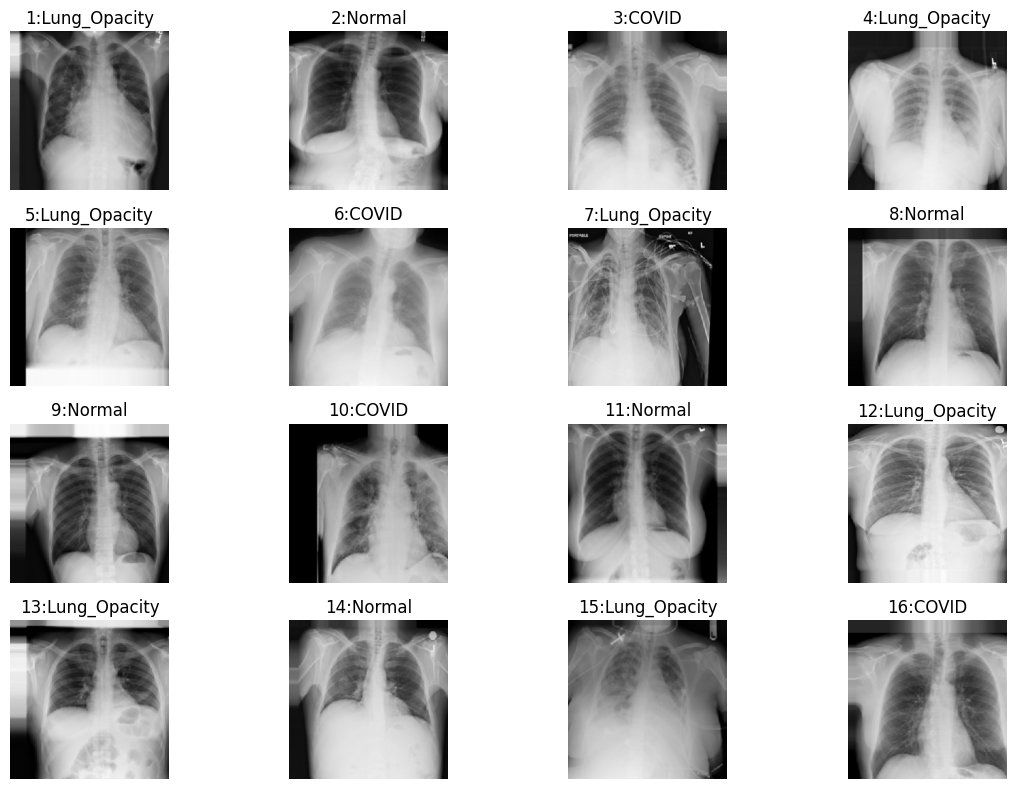

In [ ]:
class_names = {0:'COVID', 1:'Lung_Opacity', 2:'Normal', 3:'Viral Pneumonia'}

plt.figure(figsize=(12,8))

for i in range(0,16):
  plt.subplot(4, 4, i+1)
  plt.title(str(i+1)+ ":" + class_names[label[i]])
  plt.imshow(data[i])                                  # imshow = img show
  plt.axis("off")

plt.tight_layout()

## 2-3. MobileNet을 사용하여 학습

In [ ]:
### 분류기: 사전 학습된 imagenet의 가중치 사용
base_model = MobileNet(weights= "imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
### include_top=False이기 때문에 학습기(FC)만 생성
model = Sequential()

# 입력층
model.add(base_model)
model.add(Flatten())

# 은닉층
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))

# 출력층
model.add(Dense(4, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate= 1e-4), metrics=["accuracy"])

start_time = datetime.now()

result = model.fit(train_generator, epochs=30, validation_data = valid_generator)

end_time = datetime.now()

print("걸린 시간: ", end_time - start_time)

Epoch 1/30
424/424 [==============================] - 225s 471ms/step - loss: 0.8147 - accuracy: 0.6608 - val_loss: 0.3975 - val_accuracy: 0.8484
Epoch 2/30
424/424 [==============================] - 193s 455ms/step - loss: 0.5247 - accuracy: 0.8183 - val_loss: 0.3976 - val_accuracy: 0.9043
Epoch 3/30
424/424 [==============================] - 194s 456ms/step - loss: 0.4423 - accuracy: 0.8704 - val_loss: 0.3409 - val_accuracy: 0.9093
Epoch 4/30
424/424 [==============================] - 196s 462ms/step - loss: 0.3746 - accuracy: 0.8885 - val_loss: 0.3551 - val_accuracy: 0.9040
Epoch 5/30
424/424 [==============================] - 193s 454ms/step - loss: 0.3759 - accuracy: 0.8877 - val_loss: 0.4142 - val_accuracy: 0.8874
Epoch 6/30
424/424 [==============================] - 195s 459ms/step - loss: 0.3430 - accuracy: 0.8977 - val_loss: 0.3144 - val_accuracy: 0.9256
Epoch 7/30
424/424 [==============================] - 190s 448ms/step - loss: 0.3015 - accuracy: 0.9121 - val_loss: 0.2671 -

## 2-4. 학습 성능 시각화

In [ ]:
print(model.evaluate(test_generator))  # 평가는 test_generator로.

133/133 [==============================] - 48s 362ms/step - loss: 0.2431 - accuracy: 0.9381
[0.24313558638095856, 0.9380907416343689]


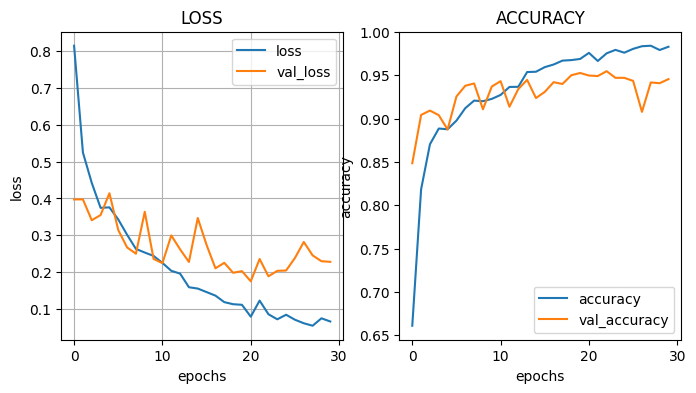

In [ ]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history['loss'], label="loss")
plt.plot(result.history['val_loss'], label="val_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.plot(result.history['accuracy'], label="accuracy")
plt.plot(result.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="best")

- 정확도는 높게 나왔으나 과적합이 있음. -> 튜닝이 필요

## 2-5. 파인 튜닝1

- 과적합이 있기 때문에, Dropout 비율을 0.3 -> 0.4 로 높인다.

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# 폐 사진의 특징을 고려했을 때, 이미지를 회전 시켜서는 안 됨. 따라서 rotation_range는 사용X
# width_shift_range 와 height_shift_range만 사용

train_data = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1, validation_split = 0.2) # train 데이터 셋에서
valid_data = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1,validation_split = 0.2) # validation 데이터 사용
test_data  = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1)

train_generator = train_data.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse", subset="training")

valid_generator = valid_data.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse", subset="validation")

test_generator = test_data.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse")


### 분류기: 사전 학습된 imagenet의 가중치 사용
base_model = MobileNet(weights= "imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

### include_top=False이기 때문에 학습기(FC)만 생성
model = Sequential()

# 입력층
model.add(base_model)
model.add(Flatten())

# 은닉층
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.4))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.4))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4))

# 출력층
model.add(Dense(4, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate= 1e-4), metrics=["accuracy"])

start_time = datetime.now()

result = model.fit(train_generator, epochs=30, validation_data = valid_generator)

end_time = datetime.now()

print("걸린 시간: ", end_time - start_time)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/30
424/424 [==============================] - 223s 460ms/step - loss: 1.2836 - accuracy: 0.5510 - val_loss: 1.0574 - val_accuracy: 0.6942
Epoch 2/30
424/424 [==============================] - 188s 444ms/step - loss: 1.1072 - accuracy: 0.5994 - val_loss: 0.9033 - val_accuracy: 0.7090
Epoch 3/30
424/424 [==============================] - 189s 447ms/step - loss: 0.9664 - accuracy: 0.6603 - val_loss: 0.8455 - val_accuracy: 0.7149
Epoch 4/30
424/424 [==============================] - 189s 445ms/step - loss: 0.9135 - accuracy: 0.6807 - val_loss: 0.7952 - val_accuracy: 0.7149
Epoch 5/30
424/424 [==============================] - 189s 445ms/step - loss: 0.7954 - accuracy: 0.7456 - val_loss: 0.6347 - val_accuracy: 0.8216
Epoch 6/30
424/424 [==============================] - 192s 452ms/step - loss: 0.6994 - accuracy: 0.7947 - val_loss: 0.5495 - val_accuracy: 0.8511
Epoch 7/30
424/424 [==============================] - 192s 

In [ ]:
print(model.evaluate(test_generator))

133/133 [==============================] - 47s 356ms/step - loss: 0.4388 - accuracy: 0.8752
[0.4387785494327545, 0.8752362728118896]


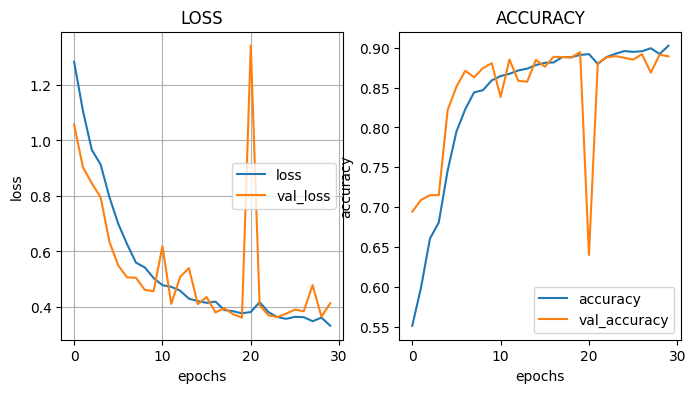

In [ ]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history['loss'], label="loss")
plt.plot(result.history['val_loss'], label="val_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.plot(result.history['accuracy'], label="accuracy")
plt.plot(result.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="best")

- 과적합은 많이 향상되었으나, 정확도가 떨어졌고 중간중간 이탈이 많음.

## 2-5. 파인 튜닝2

- Dropout 비율을 0.4 -> 0.35로 조절

In [14]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# 폐 사진의 특징을 고려했을 때, 이미지를 회전 시켜서는 안 됨. 따라서 rotation_range는 사용X
# width_shift_range 와 height_shift_range만 사용

train_data = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1, validation_split = 0.2) # train 데이터 셋에서
valid_data = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1,validation_split = 0.2) # validation 데이터 사용
test_data  = ImageDataGenerator(rescale = 1. / 255, width_shift_range=0.1,
                                height_shift_range = 0.1)

train_generator = train_data.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse", subset="training")

valid_generator = valid_data.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse", subset="validation")

test_generator = test_data.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size = 32, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 shuffle = True, color_mode = "rgb",
                                                 class_mode = "sparse")


### 분류기: 사전 학습된 imagenet의 가중치 사용
base_model = MobileNet(weights= "imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

### include_top=False이기 때문에 학습기(FC)만 생성
model = Sequential()

# 입력층
model.add(base_model)
model.add(Flatten())

# 은닉층
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.35))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.35))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.35))

# 출력층
model.add(Dense(4, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate= 1e-4), metrics=["accuracy"])

start_time = datetime.now()

result = model.fit(train_generator, epochs=30, validation_data = valid_generator)

end_time = datetime.now()

print("걸린 시간: ", end_time - start_time)

Found 13548 images belonging to 4 classes.
Found 3385 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/30
424/424 [==============================] - 257s 533ms/step - loss: 0.9783 - accuracy: 0.5980 - val_loss: 0.7337 - val_accuracy: 0.7938
Epoch 2/30
424/424 [==============================] - 214s 505ms/step - loss: 0.7208 - accuracy: 0.7603 - val_loss: 0.4858 - val_accuracy: 0.8842
Epoch 3/30
424/424 [==============================] - 221s 520ms/step - loss: 0.6027 - accuracy: 0.8206 - val_loss: 0.4291 - val_accuracy: 0.9069
Epoch 4/30
424/424 [==============================] - 219s 516ms/step - loss: 0.5644 - accuracy: 0.8272 - val_loss: 0.3881 - val_accuracy: 0.9211
Epoch 5/30
424/424 [==============================] - 219s 516ms/step - loss: 0.4990 - accuracy: 0.8538 - val_loss: 0.3577 - val_accuracy: 0.9214
Epoch 6/30
424/424 [==============================] - 219s 517ms/step - loss: 

In [15]:
print(model.evaluate(test_generator))

133/133 [==============================] - 55s 416ms/step - loss: 0.1898 - accuracy: 0.9485
[0.18984174728393555, 0.9484876990318298]


- 파인 튜닝을 마친 최종 모델의 정확도: 94%



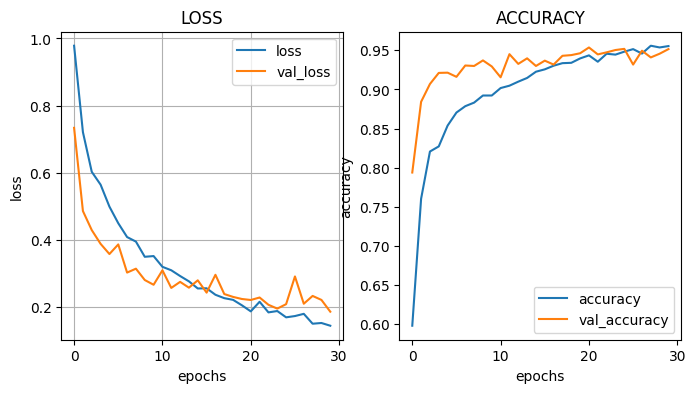

In [16]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history['loss'], label="loss")
plt.plot(result.history['val_loss'], label="val_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.plot(result.history['accuracy'], label="accuracy")
plt.plot(result.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="best")

- 파인튜닝 결과: 과적합이 해결되었고 성능도 95%에 가까움

## 2-6. 파인 튜닝2 모델 저장

In [26]:
model.save('/content/covid_19_Radiography_acc95.h5')

# 3. 예측

- 예측을 위해서는 예측하고 싶은 새로운 사진을 사용하는 것이 맞지만

- 예측을 위한 사진이 없기 때문에,test_generator() 로 만들어진 사진 16장을 사용

## 3-1. 모델 로드

In [27]:
from tensorflow.keras.models import load_model

model = load_model('/content/covid_19_Radiography_acc95.h5')

## 3-2. 예측에 사용할 사진 준비

In [37]:
data, label = test_generator.next()

np.random.seed(1)                             # 랜덤으로 셔플 하지만 seed를 이용하여 data와 label의 대응관계가 무너지지 않도록.
np.random.shuffle(np.array(data))
np.random.seed(1)
np.random.shuffle(np.array(label))

data = data[:16]     # 임의로 16장
label = label[:16]

label                # 4개의 클래스가 다 나와 있음

array([1., 2., 1., 3., 3., 2., 2., 0., 1., 2., 3., 2., 0., 1., 0., 0.],
      dtype=float32)

In [38]:
pred = model.predict(data)
pred

1/1 [==============================] - 0s 32ms/step


array([[1.1924180e-15, 9.9985099e-01, 1.4896144e-04, 2.3776606e-19],
       [6.4670952e-10, 1.0994017e-03, 9.9890053e-01, 1.9838504e-12],
       [6.4853327e-07, 9.7204161e-01, 2.7957696e-02, 9.7849799e-09],
       [1.5003238e-07, 2.8303065e-08, 1.8013177e-05, 9.9998188e-01],
       [5.5267708e-04, 8.8507732e-05, 4.1540954e-03, 9.9520469e-01],
       [1.5888470e-05, 2.6959017e-02, 9.7302431e-01, 8.3073559e-07],
       [1.5696201e-10, 1.2004486e-03, 9.9879956e-01, 2.3782276e-13],
       [9.1534430e-01, 1.0518361e-02, 1.1826674e-02, 6.2310580e-02],
       [3.5701597e-09, 9.9478120e-01, 5.2187489e-03, 1.9133264e-11],
       [1.1934108e-07, 5.8703697e-03, 9.9412954e-01, 9.0593139e-10],
       [8.5657462e-03, 1.4885475e-03, 3.7152186e-02, 9.5279354e-01],
       [7.7884062e-03, 1.3673240e-01, 8.5457343e-01, 9.0571312e-04],
       [9.1534430e-01, 1.0518361e-02, 1.1826674e-02, 6.2310580e-02],
       [2.1954579e-16, 9.9989974e-01, 1.0020800e-04, 5.1984547e-20],
       [9.1534430e-01, 1.0518361e-

## 3-3. 예측 결과 시각화

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 예측된 라벨을 실제 라벨과 비교
predicted_labels = np.argmax(pred, axis=1)  # 가장 높은 확률 값을 가진 클래스로 예측된 라벨
true_labels = label[:16]                    # 실제 데이터의 라벨

# 정확도 계산
accuracy = np.mean(predicted_labels == true_labels)
print("예측 정확도:", accuracy)

print("============================================")

# Confusion matrix 계산
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix")
print(cm)

예측 정확도: 1.0
Confusion Matrix
[[4 0 0 0]
 [0 4 0 0]
 [0 0 5 0]
 [0 0 0 3]]


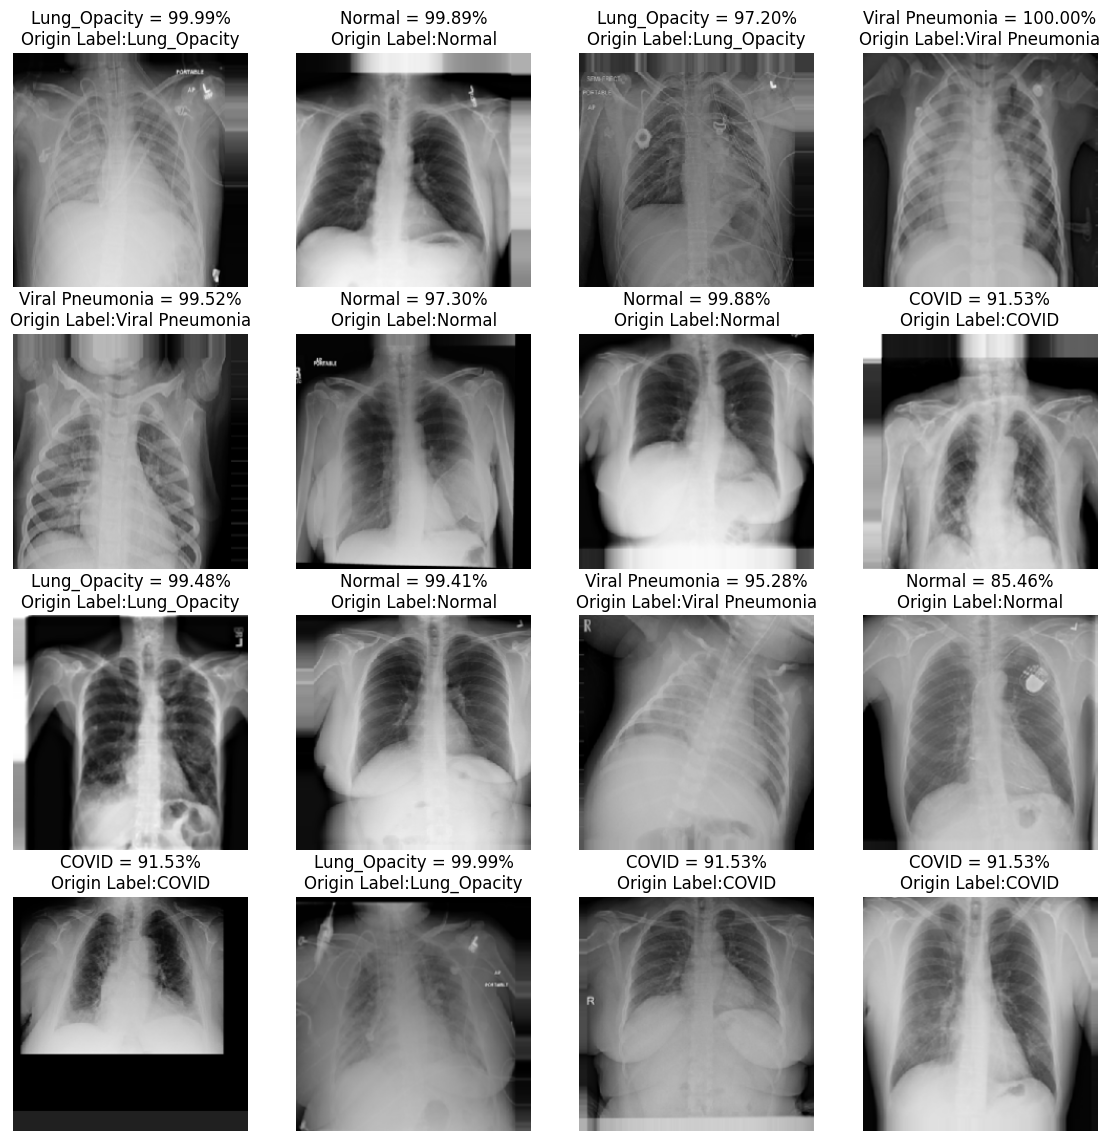

In [40]:
plt.figure(figsize=(14, 14))

class_name = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]   # softmax일 때

for i in range(len(pred)):
  plt.subplot(4, 4, i+1)
  plt.axis('off')

  prediction = class_name[np.argmax(pred[i])]             # softmax일 때는 모든 레이블에 대한 예측 확률이 나오기 때문에 np.argmax를 사용

  prob_str=str("{0:0.2f}".format(100*max(pred[i])))+ "%"
  plt.title(prediction + " = " + prob_str + "\n" + "Origin Label:" + class_name[int(label[i])])
  plt.imshow(data[i])

- 16개의 사진 모든 예측에 성공하였음
- 하지만 모델의 손실이 19%, 정확도가 94.84%이기 때문에 완전하다고 볼 수 없음